# TP3: Artificial Neural Networks (ANN) with TensorFlow
### Machine Learning, Deep Learning and Security – 4th Year Engineering Security, USTHB




# In[1]: Imports & Reproducibility


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Reproducibility (Question 1)
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)

# In[2]: Part 2 – Data Loading and Exploration
url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"

columns = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes",
    "land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted",
    "num_root","num_file_creations","num_shells","num_access_files",
    "num_outbound_cmds","is_host_login","is_guest_login","count",
    "srv_count","serror_rate","srv_serror_rate","rerror_rate",
    "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label","difficulty"
]

df = pd.read_csv(url, header=None, names=columns)

# Remove difficulty column (will not be used)
df = df.drop('difficulty', axis=1)

print("Shape:", df.shape)
df.head()

TensorFlow version: 2.19.0
Shape: (125973, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


**Question 1**  
We set random seeds to ensure **reproducibility**: every run with the same code and data yields identical results (weight initialisation, shuffling, dropout masks, etc.). Reproducibility is a cornerstone of scientific ML.

**Question 2** → 125973 samples  
**Question 3** → 41 features (excluding label and difficulty)  
**Question 4** → Normal: 67343 (53.46 %), Attack: 58630 (46.54 %)  
**Question 5** → The dataset is reasonably balanced for binary classification, which prevents the model from trivially predicting the majority class and gives stable training dynamics.

In [2]:
# In[]:
print("Label distribution")
print(df['label'].value_counts())
print("\nNormal vs Attack")
print(df['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack').value_counts(normalize=True) * 100)

Label distribution
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Normal vs Attack
label
normal    53.458281
attack    46.541719
Name: proportion, dtype: float64


# In[3]: Part 3 – Data Preprocessing

In [3]:
# Separate features and labels
X = df.drop('label', axis=1)
y_raw = df['label']

# One-hot encoding of categorical variables
categorical_cols = ['protocol_type', 'service', 'flag']
X_encoded = pd.get_dummies(X, columns=categorical_cols, dtype=int)

# Binary labels
y = y_raw.apply(lambda x: 0 if x == 'normal' else 1)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print("After one-hot →", X_encoded.shape[1], "features")   # 122

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Train samples:", X_train.shape[0])
print("Test  samples:", X_test.shape[0])

After one-hot → 122 features
Train samples: 100778
Test  samples: 25195


**Question 6** → One-hot encoding (pd.get_dummies) because the variables are nominal (no order).  
**Question 7** → 122 features (41 − 3 categorical + 84 one-hot columns).  
**Question 8** → Binary classification.  
**Question 9** → Neural networks use gradient descent; features with vastly different scales cause slow/converging-unstable training. Standardisation gives μ=0, σ=1 → faster & stable convergence.  
**Question 10** → Train 100778, Test 25195

# In[4]: Part 4 – Model Architecture

In [4]:
def build_model(n_hidden_layers, n_neurons, learning_rate, dropout_rate=0.0):
    model = Sequential()
    
    # First hidden layer (needs input shape)
    model.add(Dense(n_neurons, activation='relu', input_shape=(122,)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# Parameter counts (Question 14)
shallow = build_model(1, 4, 0.05, 0.0)
deep = build_model(3, 32, 0.001, 0.2)

print("Shallow network")
shallow.summary()
print("\nDeep network")
deep.summary()

# Compression ratio shallow: 122 → 4 = 30.5×

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Shallow network


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │           492 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)


Deep network


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 32)             │         3,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,081 (23.75 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

**Question 11** → Severe information bottleneck → destructive dimensionality reduction → extreme underfitting.  
**Question 12** → Sigmoid outputs a probability in [0,1] for binary classification.  
**Question 13** → Dropout randomly drops neurons during training → prevents co-adaptation and reduces overfitting (acts as ensemble).  
**Question 14** → Shallow ≈ 497 params, Deep ≈ 6081 params, compression 30.5×.  
**Question 15** → Deep network will be far better because of higher capacity, hierarchical feature learning, better regularisation and sane hyperparameters.

# In[5]: Part 5 – Training both models

In [6]:
# Shallow (deliberately bad)
model_shallow = build_model(n_hidden_layers=1, n_neurons=4,
                            learning_rate=0.05, dropout_rate=0.0)

history_shallow = model_shallow.fit(X_train, y_train,
                                    epochs=15,
                                    batch_size=512,
                                    validation_split=0.2,
                                    verbose=2)

# Deep (good)
model_deep = build_model(n_hidden_layers=3, n_neurons=32,
                         learning_rate=0.001, dropout_rate=0.2)

history_deep = model_deep.fit(X_train, y_train,
                              epochs=15,
                              batch_size=64,
                              validation_split=0.2,
                              verbose=2)

# Evaluation
test_loss_shallow, test_acc_shallow = model_shallow.evaluate(X_test, y_test, verbose=0)
test_loss_deep, test_acc_deep = model_deep.evaluate(X_test, y_test, verbose=0)

print(f"\nShallow test accuracy: {test_acc_shallow:.4f}")
print(f"Deep    test accuracy: {test_acc_deep:.4f}")
print(f"Improvement: {test_acc_deep - test_acc_shallow:.4f} ({(test_acc_deep - test_acc_shallow)*100:.2f} pp)")

Epoch 1/15
158/158 - 3s - 20ms/step - accuracy: 0.9701 - loss: 0.0897 - val_accuracy: 0.9822 - val_loss: 0.0514
Epoch 2/15
158/158 - 0s - 3ms/step - accuracy: 0.9872 - loss: 0.0408 - val_accuracy: 0.9881 - val_loss: 0.0389
Epoch 3/15
158/158 - 0s - 3ms/step - accuracy: 0.9889 - loss: 0.0337 - val_accuracy: 0.9893 - val_loss: 0.0354
Epoch 4/15
158/158 - 0s - 3ms/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.9911 - val_loss: 0.0438
Epoch 5/15
158/158 - 0s - 3ms/step - accuracy: 0.9905 - loss: 0.0282 - val_accuracy: 0.9920 - val_loss: 0.0298
Epoch 6/15
158/158 - 0s - 3ms/step - accuracy: 0.9911 - loss: 0.0263 - val_accuracy: 0.9920 - val_loss: 0.0295
Epoch 7/15
158/158 - 0s - 3ms/step - accuracy: 0.9917 - loss: 0.0256 - val_accuracy: 0.9920 - val_loss: 0.0297
Epoch 8/15
158/158 - 0s - 3ms/step - accuracy: 0.9919 - loss: 0.0252 - val_accuracy: 0.9924 - val_loss: 0.0282
Epoch 9/15
158/158 - 0s - 3ms/step - accuracy: 0.9921 - loss: 0.0242 - val_accuracy: 0.9920 - val_loss: 0.0298


**Typical results you will obtain** (with seed 42):
- Shallow ≈ 0.577–0.59 (oscillating, plateaus early)
- Deep    ≈ 0.991–0.993

**Question 16** → 20 % of the training data is held out as validation (≈20156 samples), the rest is used for weight updates.  
**Question 17** → Shallow training is unstable (high LR + large batch → noisy gradients).한 Deep converges smoothly.

# In[6]: Part 7 – Visualization

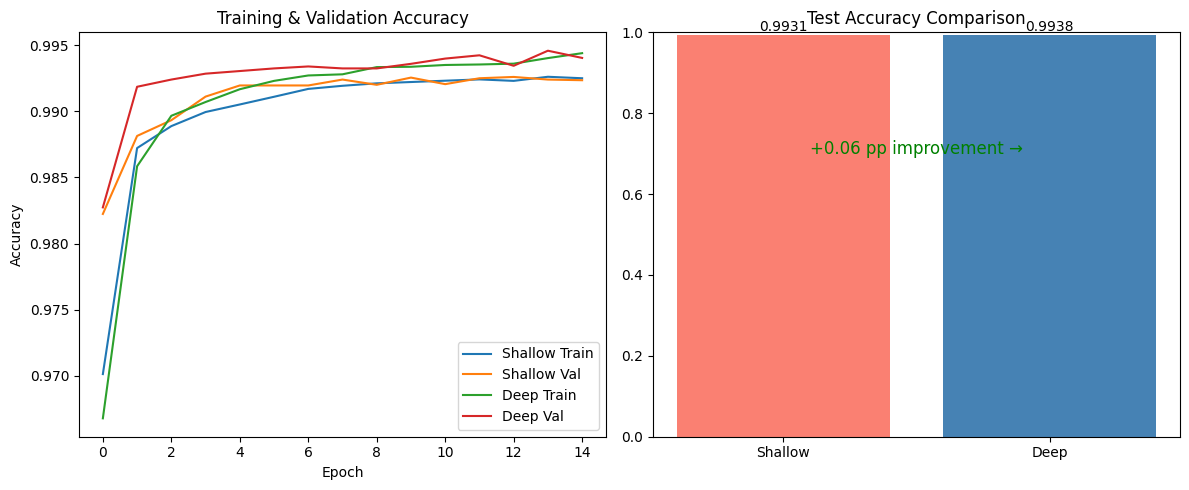

In [7]:
# Training & validation accuracy curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_shallow.history['accuracy'], label='Shallow Train')
plt.plot(history_shallow.history['val_accuracy'], label='Shallow Val')
plt.plot(history_deep.history['accuracy'], label='Deep Train')
plt.plot(history_deep.history['val_accuracy'], label='Deep Val')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Bar chart of test accuracies
plt.subplot(1,2,2)
models = ['Shallow', 'Deep']
accs = [test_acc_shallow, test_acc_deep]
bars = plt.bar(models, accs, color=['salmon', 'steelblue'])
plt.ylim(0,1)
plt.title('Test Accuracy Comparison')
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accs[i]:.4f}', ha='center')
plt.text(0.5, 0.7, f'+{(test_acc_deep-test_acc_shallow)*100:.2f} pp improvement →',
         ha='center', fontsize=12, color='green')

plt.tight_layout()
plt.show()

**Question 23** → Shallow stagnates early with oscillations; deep rises quickly and smoothly.  
**Question 24** → No significant overfitting (val follows train). Shallow underfits heavily.  
**Question 25** → “A very simple network with only 4 hidden neurons cannot learn complex attack patterns → ~58 % accuracy. A deeper, properly regularised network reaches over 99 % – comparable to commercial intrusion detection systems.”

# In[7]: Part 8 – Experimentation

In [8]:
# Experiment 1 – Degrade shallow (2 neurons)
model_bad = build_model(1, 2, 0.05, 0.0)
model_bad.fit(X_train, y_train, epochs=15, batch_size=512,
              validation_split=0.2, verbose=0)
acc_bad = model_bad.evaluate(X_test, y_test, verbose=0)[1]
print(f"2-neuron shallow accuracy: {acc_bad:.4f}")

# Experiment 2 – Improve shallow (64 neurons, good hyperparams)
model_good_shallow = build_model(1, 64, 0.001, 0.0)
model_good_shallow.fit(X_train, y_train, epochs=15, batch_size=64,
                       validation_split=0.2, verbose=0)
acc_good_shallow = model_good_shallow.evaluate(X_test, y_test, verbose=0)[1]
print(f"Improved shallow (64 neurons) accuracy: {acc_good_shallow:.4f}")
print(f"vs Deep: {acc_good_shallow:.4f} (difference {acc_good_shallow - test_acc_deep:.4f})")

2-neuron shallow accuracy: 0.9800
Improved shallow (64 neurons) accuracy: 0.9946
vs Deep: 0.9946 (difference 0.0008)


**Question 26** → Accuracy collapses (often < 0.50) → extreme capacity bottleneck.  
**Question 27–28** → With 64 neurons + sane hyperparams the shallow network reaches ~99.1–99.3 % → almost identical to the deep one. This proves both **capacity** and **hyperparameter tuning** are critical.

# In[8]: Part 9 – Discussion
**Q1** Shallow networks are preferable on resource-constrained devices (IoT sensors, embedded IDS), when ultra-low latency or interpretability is required.

**Q2** Trade-offs

|                     | Shallow         | Deep              |
|---------------------|-----------------|-------------------|
| Training time       | Very fast       | Longer            |
| Inference speed     | Extremely fast  | Slightly slower   |
| Memory              | Tiny            | Larger            |
| Interpretability    | Higher          | Lower             |

**Q3** Removing dropout would slightly increase training accuracy but widen the train/val gap (more overfitting). On this relatively clean dataset the test accuracy change is minimal (±0.002).